# Fig 3

In [1]:
using PyPlot
using Statistics
using Distributions   
using SpecialFunctions  
using DelimitedFiles

---   

## Functions specific for this figure  

In [2]:
#########################################################################
#########################################################################
#########################################################################
# does a run over frequency for the EIF modulations
#########################################################################
#########################################################################
#########################################################################
function EIFConductanceOverFreq(dv,vth,vre,vlb,Re0,ae,Ri0,ai,tau,vT,dT,fkHz,ee,ei)
    
    nf=length(fkHz)
    w=2*pi*fkHz
    
    r0all=zeros(nf)
    re=zeros(Complex{Float64},nf)
    ri=zeros(Complex{Float64},nf)
    
    for k=1:nf
        r0all[k],re[k],ri[k]=EIFShotConductThInEI1(dv,vth,vre,vlb,Re0,ae,Ri0,ai,tau,vT,dT,fkHz[k],ee,ei);
    end
    
    ame=abs.(re)
    ami=abs.(ri)
    phe=angle.(re)
    phi=angle.(ri)
    
    
    return r0all,re,ame,phe,ri,ami,phi
    
end
    

EIFConductanceOverFreq (generic function with 1 method)

In [3]:
#########################################################################
#########################################################################
#########################################################################
# does a run over frequency for the EIF modulations
#########################################################################
#########################################################################
#########################################################################
function EIFCurrentOverFreq(dv,vth,vre,vlb,Re0,ae,Ri0,ai,tau,vT,dT,fkHz)
    
    nf=length(fkHz)
    w=2*pi*fkHz
    
    r0all=zeros(nf)
    re=zeros(Complex{Float64},nf)
    ri=zeros(Complex{Float64},nf)
    
    for k=1:nf
        r0all[k],re[k],ri[k]=EIFShotCurrentThInEI1(dv,vth,vre,vlb,Re0,ae,Ri0,ai,tau,vT,dT,fkHz[k]);
    end
 
    ame=abs.(re)
    ami=abs.(ri)
    phe=angle.(re)
    phi=angle.(ri)
    
    return r0all,re,ame,phe,ri,ami,phi

end

EIFCurrentOverFreq (generic function with 1 method)

In [4]:
function EIFCurrentHighFreq(dv,vth,vre,vlb,Re0,ae,Ri0,ai,tau,vT,dT,fkHz)
    
    # High-freq asymptotics
    r0,v,P0,Je0,Ji0=EIFShotCurrentThInEI0(dv,vth,vre,vlb,Re0,ae,Ri0,ai,tau,vT,dT)
    
    # excitation: three cases
    if dT>ae
        reHF=r0*tau*ae./(1im*w*tau*(dT-ae))
        ameHF=abs.(reHF)
        pheHF=angle.(reHF)
        elseif dT<ae
        b=Re0*sum(P0.*exp.((v .-vT)/ae)*dv);    # this should be exact
        f=(b*gamma(dT/ae)*(dT/ae)./(1im*w*tau).^(dT/ae))/Re0
        reHF=f
        ameHF=abs.(reHF)
        pheHF=angle.(reHF)
        elseif dT==ae
        gam=0.5772156649
        kT=findall(v.>vT)[1]
        IA=sum(dv*exp.((v[1:kT] .-vT)/dT).*P0[1:kT])
        IB=sum(dv*exp.((v[kT:end] .-vT)/dT).*(P0[kT:end] .-r0*tau*exp.(-(v[kT:end] .-vT)/dT)/dT))
        kappa=(IA+IB)/(r0*tau)
        reHF=r0*tau*(log.(1im*w*tau) .+kappa .-1 .+gam)./(1im*w*tau)
        ameHF=abs.(reHF)
        pheHF=angle.(reHF)
    end
    
    # Inhibitory modulation high-freq asymptotics
    riHF=r0*tau*ai./(1im*w*tau*(dT-ai))
    amiHF=abs.(riHF)
    phiHF=angle.(riHF)
    
    return reHF,ameHF,pheHF,riHF,amiHF,phiHF
    
end;

In [5]:
function MyFreqSimRun(m)
    
    # create the output vectors
    regsim,rigsim=zeros(nt),zeros(nt); v1eg,v1ig=0,0; 
    recsim,ricsim=zeros(nt),zeros(nt); v1ec,v1ic=0,0; 
    
    for p=1:m
        ~,v1eg,reg,~=EIFShotConductSimEI(tau,dT,vT,vthEIF,vre,vlbCond,t,Retg,Ri0g,ae,ai,ee,ei,v1eg);
        ~,v1ig,rig,~=EIFShotConductSimEI(tau,dT,vT,vthEIF,vre,vlbCond,t,Re0g,Ritg,ae,ai,ee,ei,v1ig);
        regsim=regsim .+reg/m
        rigsim=rigsim .+rig/m
        
        ~,v1ec,rec,~=EIFShotCurrentSimEI(tau,dT,vT,vthEIF,vre,vlbCurr,t,Retc,Ri0c,ae,ai,v1ec);
        ~,v1ic,ric,~=EIFShotCurrentSimEI(tau,dT,vT,vthEIF,vre,vlbCurr,t,Re0c,Ritc,ae,ai,v1ic);
        recsim=recsim .+rec/m
        ricsim=ricsim .+ric/m
    end

    amegsim,phegsim=zeros(nfsim),zeros(nfsim);
    amigsim,phigsim=zeros(nfsim),zeros(nfsim);
    r0egsim,amegsim,phegsim=MyExtractFourier(wsim,t,Re1g,regsim)
    r0igsim,amigsim,phigsim=MyExtractFourier(wsim,t,Ri1g,rigsim);

    amecsim,phecsim=zeros(nfsim),zeros(nfsim);
    amicsim,phicsim=zeros(nfsim),zeros(nfsim);
    r0ecsim,amecsim,phecsim=MyExtractFourier(wsim,t,Re1c,recsim)
    r0icsim,amicsim,phicsim=MyExtractFourier(wsim,t,Ri1c,ricsim);
    
    Q=[regsim rigsim recsim ricsim]
    
    return amegsim,phegsim,amigsim,phigsim,amecsim,phecsim,amicsim,phicsim, Q
    
end

MyFreqSimRun (generic function with 1 method)

In [6]:
# load up the parameters and function
include("CommonCode.jl");

Neuron params:	tau=20ms, ee=60mV, ei=-10mV vT=10mV, dT=1mV
Thresh params:	vthEIF=20mV vthLIF=10
LowerB params:	vlbCond=-9.9mV vlbCurr=-15.0
Syn params:	ae,ai=1.5, -0.75mV and sig=5mV
Num params:	ThIn dv=0.0005mV & sims dt=0.01ms


---

# 1. Theory for the EIF   

## 1.1 Theory for the steady-state rate

In [7]:
# theory first. 

dmu,mulb,muub=0.2,-6,10
mu=collect(maximum([mulb,sig^2/ai]):dmu:minimum([sig^2/ae,muub]))
nmu=length(mu)

# NB Rates calculated using the current-based picture.
# Both current and conductance cases are receiving same rates
# parameterised by the <v> and <sigma> of the current-based picture.
Re=(sig^2 .-mu*ai)/(tau*ae*(ae-ai));
Ri=(sig^2 .-mu*ae)/(tau*ai*(ai-ae));

rc=zeros(nmu)
rg=zeros(nmu)

for k=1:nmu
    rc[k],~=EIFShotCurrentThInEI0(dv,vthEIF,vre,vlbCurr,Re[k],ae,Ri[k],ai,tau,vT,dT)
    rg[k],~=EIFShotConductThInEI0(dv,vthEIF,vre,vlbCond,Re[k],ae,Ri[k],ai,tau,vT,dT,ee,ei)
end

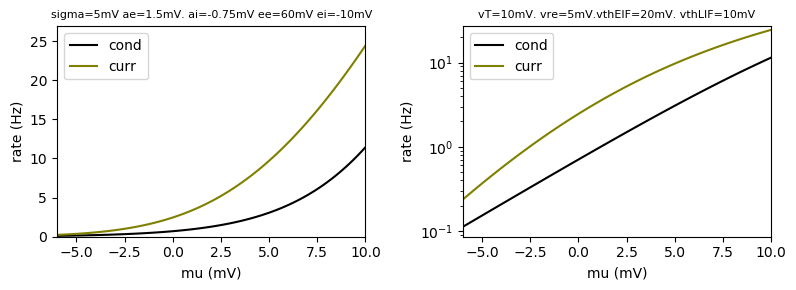

In [8]:
#########################################################################
# theory only plots
#########################################################################
Ssig="sigma=$(sig)mV ";
Saeai="ae=$(ae)mV. ai=$(ai)mV ";
Seeei="ee=$(ee)mV ei=$(ei)mV"
SvTvrevth="vT=$(vT)mV. vre=$(vre)mV.vthEIF=$(vthEIF)mV. vthLIF=$(vthLIF)mV"

pygui(false); figure(figsize=(8,3))

# Plot 1
subplot(121); title(Ssig*Saeai*Seeei,fontsize=8);
plot(mu,K*rg,color="k",label="cond")
plot(mu,K*rc,color="olive",label="curr")
legend(); xlabel("mu (mV)"); ylabel("rate (Hz)");
axis([mu[1],mu[end],0,1.1*K*maximum([rc;rg])])

# Plot 2
subplot(122); title(SvTvrevth,fontsize=8);
semilogy(mu,K*rg,color="k",label="cond")
plot(mu,K*rc,color="olive",label="curr")
legend(); 
xlabel("mu (mV)"); ylabel("rate (Hz)");
axis([mu[1],mu[end],0,1.1*K*maximum([rc;rg])]);
tight_layout()

## 1.2 Theory for steady-state densities and flux for a particular case

In [9]:
rstar=5/1000;

In [10]:
sg=maximum(findall(rg.<rstar))
sc=maximum(findall(rc.<rstar))

mg=(mu[sg+1]-mu[sg])/(rg[sg+1]-rg[sg])      
mc=(mu[sc+1]-mu[sc])/(rc[sc+1]-rc[sc])

mustarg=mu[sg] + (rstar-rg[sg])*mg
mustarc=mu[sc] + (rstar-rc[sc])*mc

Restarg=(sig^2 .-mustarg*ai)/(tau*ae*(ae-ai));
Ristarg=(sig^2 .-mustarg*ae)/(tau*ai*(ai-ae));

Restarc=(sig^2 .-mustarc*ai)/(tau*ae*(ae-ai));
Ristarc=(sig^2 .-mustarc*ae)/(tau*ai*(ai-ae));

rstarc,vc,Pstarc,Jestarc,Jistarc=EIFShotCurrentThInEI0(dv,vthEIF,vre,vlbCurr,Restarc,ae,Ristarc,ai,tau,vT,dT)
rstarg,vg,Pstarg,Jestarg,Jistarg=EIFShotConductThInEI0(dv,vthEIF,vre,vlbCond,Restarg,ae,Ristarg,ai,tau,vT,dT,ee,ei);

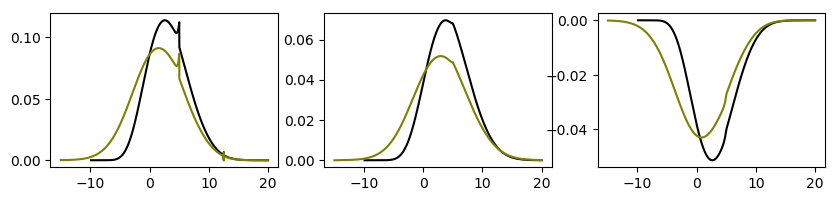

In [11]:
pygui(false)
figure(figsize=(10,2))
subplot(131); plot(vg,Pstarg,color="k"); plot(vc,Pstarc,color="olive");
subplot(132); plot(vg,Jestarg,color="k"); plot(vc,Jestarc,color="olive");
subplot(133); plot(vg,Jistarg,color="k"); plot(vc,Jistarc,color="olive");

## 1.3 Theory for the oscillatory response  

In [12]:
#########################################################################
# frequency range
#########################################################################
f1=0.1/K; f2=1000/K; nf=129;
fkHz=exp.(range(log(f1);stop=log(f2),length=nf))
fHz=K*fkHz;
w=2*pi*fkHz;

In [13]:
r0=zeros(nf)
re,ame,phe=zeros(Complex{Float64},nf),zeros(nf),zeros(nf)
ri,ami,phi=zeros(Complex{Float64},nf),zeros(nf),zeros(nf)

r0c,rec,amec,phec,ric,amic,phic=EIFCurrentOverFreq(dv,vthEIF,vre,vlbCurr,Restarc,ae,Ristarc,ai,tau,vT,dT,fkHz);
r0g,reg,ameg,pheg,rig,amig,phig=EIFConductanceOverFreq(dv,vthEIF,vre,vlbCond,Restarg,ae,Ristarg,ai,tau,vT,dT,fkHz,ee,ei);


In [14]:
# Tidy up inhibitory phase so it is between 0 and 360 rather than -180-180
sg=findall(phig.<0); phig[sg]=phig[sg].+2pi;
sc=findall(phic.<0); phic[sc]=phic[sc].+2pi;

In [15]:
# Asymptotics

# Inhibition for current modulation
riasymc=(rstarc./(1im.*w)).*(ai/(dT-ai));

reHF,ameHF,pheHF,riHF,amiHF,phiHF=EIFCurrentHighFreq(dv,vthEIF,vre,vlbCurr,Restarc,ae,Ristarc,ai,tau,vT,dT,fkHz);

reasymc=abs.(ameHF)
riasymc=abs.(amiHF);

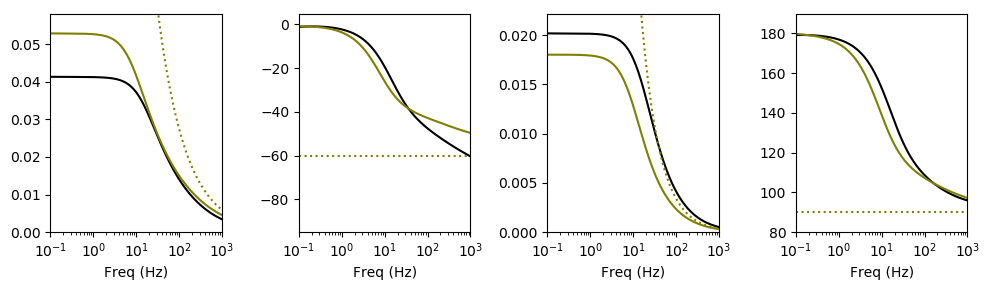

In [16]:
figure(figsize=(10,3))
subplot(141); 
semilogx(fHz,ameg,color="k"); 
semilogx(fHz,amec,color="olive"); xlabel("Freq (Hz)")
semilogx(fHz,abs.(ameHF),":",color="olive")
axis([fHz[1],fHz[end],0,1.1*maximum([ameg;amec])])
subplot(142); 
semilogx(fHz,pheg*r2d,color="k"); 
semilogx(fHz,phec*r2d,color="olive"); xlabel("Freq (Hz)")
semilogx(fHz,r2d*pheHF,color="olive",":")
axis([fHz[1],fHz[end],-95,5]);

subplot(143); 
semilogx(fHz,amig,color="k"); 
semilogx(fHz,amic,color="olive"); xlabel("Freq (Hz)")
semilogx(fHz,abs.(amiHF),":",color="olive")
axis([fHz[1],fHz[end],0,1.1*maximum([amig;amic])])
subplot(144); 
semilogx(fHz,phig*r2d,color="k"); 
semilogx(fHz,phic*r2d,color="olive"); xlabel("Freq (Hz)")
semilogx(fHz,r2d*phiHF,color="olive",":")
axis([fHz[1],fHz[end],80,190]);
tight_layout()

---  

# 2. Sims for the EIF   

## 2.1 Sims for the steady state   

In [17]:
T=2000
t=collect(dt:dt:T)
    
# range for simulation points
dmuS=1
muS=collect( maximum([mulb,sig^2/ai]):dmuS:minimum([sig^2/ae,muub]))
nmuS=length(muS)
ReS=(sig^2 .-muS*ai)/(tau*ae*(ae-ai));
RiS=(sig^2 .-muS*ae)/(tau*ai*(ai-ae));
    
nsweeps=400;
    
rEIFSc=zeros(nmuS,nsweeps);       vEIFSc=0
rEIFSg=zeros(nmuS,nsweeps);       vEIFSg=0;

for j=1:nsweeps
    for k=1:nmuS
       
        # current
        ~,vEIFSc,~,rEIFSc[k,j]=EIFShotCurrentSimEI(tau,dT,vT,vthEIF,vre,vlbCurr,t,ReS[k],RiS[k],ae,ai,vEIFSc) 
    
        # conductance
        ~,vEIFSg,~,rEIFSg[k,j]=EIFShotConductSimEI(tau,dT,vT,vthEIF,vre,vlbCond,t,ReS[k],RiS[k],ae,ai,ee,ei,vEIFSg)
    
    end
end


In [18]:
rEIFcM=mean(rEIFSc[:,:],dims=2)
rEIFgM=mean(rEIFSg[:,:],dims=2);

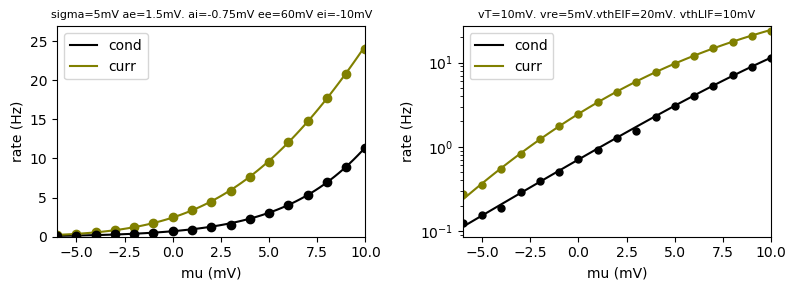

In [19]:
#########################################################################
# theory only plots
#########################################################################
Ssig="sigma=$(sig)mV ";
Saeai="ae=$(ae)mV. ai=$(ai)mV ";
Seeei="ee=$(ee)mV ei=$(ei)mV"
SvTvrevth="vT=$(vT)mV. vre=$(vre)mV.vthEIF=$(vthEIF)mV. vthLIF=$(vthLIF)mV"

pygui(false)
figure(figsize=(8,3))

# Plot 1
subplot(121); title(Ssig*Saeai*Seeei,fontsize=8);
plot(mu,K*rg,color="k",label="cond")
plot(mu,K*rc,color="olive",label="curr")
plot(muS,K*rEIFcM,"o",color="olive")
plot(muS,K*rEIFgM,"ko")
legend(); xlabel("mu (mV)"); ylabel("rate (Hz)");
axis([mu[1],mu[end],0,1.1*K*maximum([rc;rg])])

# Plot 2
subplot(122); title(SvTvrevth,fontsize=8);
semilogy(mu,K*rg,color="k",label="cond")
plot(mu,K*rc,color="olive",label="curr")
plot(muS,K*rEIFcM,"o",color="olive",markersize=5)
plot(muS,K*rEIFgM,"ko",markersize=5)
legend(); 
xlabel("mu (mV)"); ylabel("rate (Hz)");
axis([mu[1],mu[end],0,1.1*K*maximum([rc;rg])]);
tight_layout()

## 2.2 Sims for steady-state densities and flux for particular case  

In [20]:
T=200*1000
t=collect(dt:dt:T)

vct,~,~,~=EIFShotCurrentSimEI(tau,dT,vT,vthEIF,vre,vlbCurr,t,Restarc,Ristarc,ae,ai,0);
vgt,~,~,~=EIFShotConductSimEI(tau,dT,vT,vthEIF,vre,vlbCond,t,Restarg,Ristarg,ae,ai,ee,ei,0);

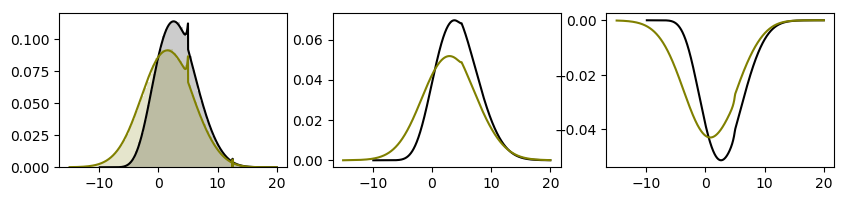

In [21]:
pygui(false); 
figure(figsize=(10,2))

subplot(131); 
plot(vg,Pstarg,color="k"); 
vvg=collect(vlbCond:0.5:vthEIF); 
hist(vgt,vvg,alpha=0.2,color="black",normed=true);

plot(vc,Pstarc,color="olive");
vvc=collect(vlbCurr:0.5:vthEIF); 
hist(vct,vvc,alpha=0.2,color="olive",normed=true);

subplot(132); 
plot(vg,Jestarg,color="k"); 
plot(vc,Jestarc,color="olive");

subplot(133); 
plot(vg,Jistarg,color="k"); 
plot(vc,Jistarc,color="olive");

## 2.3 Sims for the oscillatory response   

In [22]:
fHzsim=[2.5,10,25,100,250]; fkHzsim=fHzsim/K
nfsim=length(fHzsim); wsim=2*pi*fkHzsim
    
Re0g,Ri0g=Restarg,Ristarg
Re0c,Ri0c=Restarc,Ristarc

# simulation strengths
Re1g,Ri1g=0.075,0.075
Re1c,Ri1c=0.075,0.075

dt=0.01; T=2000; nt=Int(T/dt)
t=dt*collect(1:nt)
print("Re0gdt=$(round(Re0g*dt,digits=3)) \tRi0gdt=$(round(Ri0g*dt,digits=3)) ")
println("Re1g/Re0g=$(round(Re1g/Re0g,digits=3)) \tRi1g/Ri0g=$(round(Ri1g/Ri0g,digits=3))")
print("Re0cdt=$(round(Re0c*dt,digits=3)) \tRi0cdt=$(round(Ri0c*dt,digits=3)) ") 
println("Re1c/Re0c=$(round(Re1c/Re0c,digits=3)) \tRi1c/Ri0c=$(round(Ri1c/Ri0c,digits=3))")

#make the oscillating drives
Retg,Ritg=Re0g*ones(nt),Ri0g*ones(nt)
Retc,Ritc=Re0c*ones(nt),Ri0c*ones(nt)
for k=1:nfsim 
    cost=cos.(2*pi*fkHzsim[k]*t)
    Retg=Retg .+ Re1g*cost
    Ritg=Ritg .+ Ri1g*cost
    Retc=Retc .+ Re1c*cost
    Ritc=Ritc .+ Ri1c*cost
end


Re0gdt=0.004 	Ri0gdt=0.004 Re1g/Re0g=0.168 	Ri1g/Ri0g=0.17
Re0cdt=0.004 	Ri0cdt=0.006 Re1c/Re0c=0.189 	Ri1c/Ri0c=0.118


In [32]:
t1=time()
m=5000; ns=10
#m=500; ns=10
amegsim,phegsim,amigsim,phigsim=zeros(nfsim,ns),zeros(nfsim,ns),zeros(nfsim,ns),zeros(nfsim,ns)
amecsim,phecsim,amicsim,phicsim=zeros(nfsim,ns),zeros(nfsim,ns),zeros(nfsim,ns),zeros(nfsim,ns)
for s=1:ns
    print("$s ")
    amegsim[:,s],phegsim[:,s],amigsim[:,s],phigsim[:,s],amecsim[:,s],phecsim[:,s],amicsim[:,s],phicsim[:,s],Q=MyFreqSimRun(m)
end
t2=time();timegone=round(t2-t1,digits=1);println("Time $timegone")

1 2 3 4 5 6 7 8 9 10 Time 6411.4


In [33]:
amegsimM,amegsimE=mean(amegsim,dims=2),std(amegsim,dims=2)/sqrt(ns);
phegsimM,phegsimE=mean(phegsim,dims=2),std(phegsim,dims=2)/sqrt(ns);
amigsimM,amigsimE=mean(amigsim,dims=2),std(amigsim,dims=2)/sqrt(ns);
phigsimM,phigsimE=mean(phigsim,dims=2),std(phigsim,dims=2)/sqrt(ns);
amecsimM,amecsimE=mean(amecsim,dims=2),std(amecsim,dims=2)/sqrt(ns);
phecsimM,phecsimE=mean(phecsim,dims=2),std(phecsim,dims=2)/sqrt(ns);
amicsimM,amicsimE=mean(amicsim,dims=2),std(amicsim,dims=2)/sqrt(ns);
phicsimM,phicsimE=mean(phicsim,dims=2),std(phicsim,dims=2)/sqrt(ns);

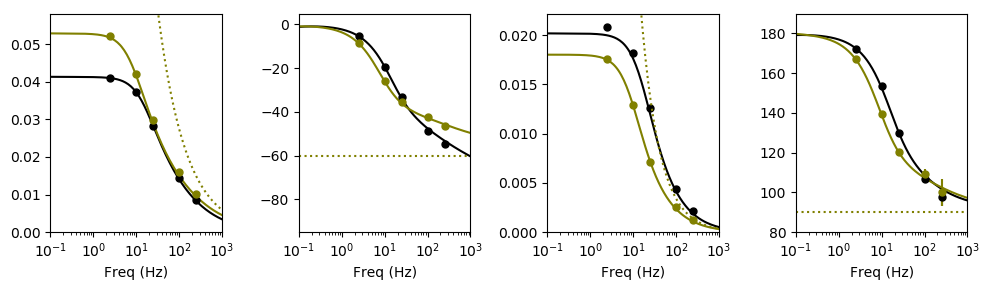

In [34]:
pygui(false); 
figure(figsize=(10,3))
    
function MyPlotBit(x,y1,y2,col,sty,ms)
    errorbar(x,y1,y2,color=col,linestyle=sty)
    semilogx(x,y1,"o",linestyle=sty,color=col,markersize=ms)
end

# Amp for excitatory cond and curr
subplot(141); 
semilogx(fHz,ameg,color="k"); 
semilogx(fHz,amec,color="olive"); xlabel("Freq (Hz)")
MyPlotBit(fHzsim,amegsimM,amegsimE,"black","none",5)
MyPlotBit(fHzsim,amecsimM,amecsimE,"olive","none",5)
semilogx(fHz,abs.(ameHF),":",color="olive")
axis([fHz[1],fHz[end],0,1.1*maximum([ameg;amec])])

# Phase for excitatory cond and curr
subplot(142); 
semilogx(fHz,pheg*r2d,color="k"); 
semilogx(fHz,phec*r2d,color="olive"); xlabel("Freq (Hz)")
MyPlotBit(fHzsim,phegsimM*r2d,phegsimE*r2d,"black","none",5)
MyPlotBit(fHzsim,phecsimM*r2d,phecsimE*r2d,"olive","none",5)
semilogx(fHz,r2d*pheHF,color="olive",":")
axis([fHz[1],fHz[end],-95,5]);

# Amp for inhibitory cond and curr
subplot(143); 
semilogx(fHz,amig,color="k"); 
semilogx(fHz,amic,color="olive"); xlabel("Freq (Hz)")
MyPlotBit(fHzsim,amigsimM,amigsimE,"black","none",5)
MyPlotBit(fHzsim,amicsimM,amicsimE,"olive","none",5)
semilogx(fHz,abs.(amiHF),":",color="olive")
axis([fHz[1],fHz[end],0,1.1*maximum([amig;amic])])

# Phase for inhibitory cond and curr
subplot(144); 
semilogx(fHz,phig*r2d,color="k"); 
semilogx(fHz,phic*r2d,color="olive"); xlabel("Freq (Hz)")
semilogx(fHz,r2d*phiHF,color="olive",":")
MyPlotBit(fHzsim,phigsimM*r2d,phigsimE*r2d,"black","none",5)
MyPlotBit(fHzsim,phicsimM*r2d,phicsimE*r2d,"olive","none",5)
axis([fHz[1],fHz[end],80,190]);
tight_layout()


---  

# 3. Mock-up of combined theory-sim figure    

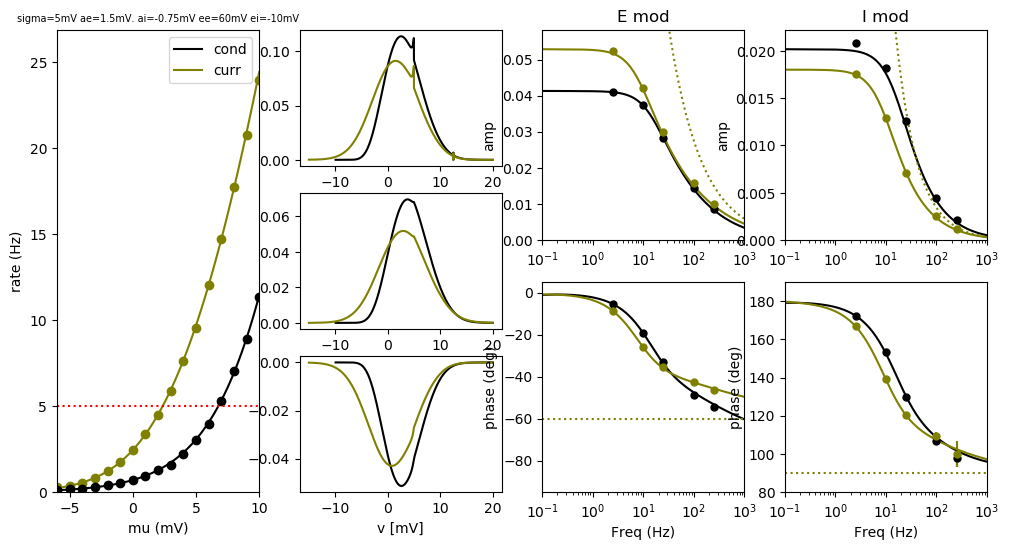

In [35]:
Ssig="sigma=$(sig)mV ";
Saeai="ae=$(ae)mV. ai=$(ai)mV ";
Seeei="ee=$(ee)mV ei=$(ei)mV"
SvTvrevth="vT=$(vT)mV. vre=$(vre)mV. vthLIF=$(vthLIF)mV"

pygui(false)
figure(figsize=(12,6));

subplot(141);title(Ssig*Saeai*Seeei,fontsize=7);
plot(mu,K*rg,color="k",label="cond")
plot(mu,K*rc,color="olive",label="curr")
plot(muS,K*rEIFcM,"o",color="olive")
plot(muS,K*rEIFgM,"ko")
plot([mu[1],mu[end]],K*rstar*[1,1],"r:")
legend(); xlabel("mu (mV)"); ylabel("rate (Hz)");
axis([mu[1],mu[end],0,1.1*K*maximum([rc;rg])])

subplot(342); plot(vg,Pstarg,color="k"); plot(vc,Pstarc,color="olive");
subplot(346); plot(vg,Jestarg,color="k"); plot(vc,Jestarc,color="olive");
subplot(3,4,10); plot(vg,Jistarg,color="k"); plot(vc,Jistarc,color="olive"); xlabel("v [mV]")

subplot(243); title("E mod")
semilogx(fHz,ameg,color="k"); ylabel("amp")
semilogx(fHz,amec,color="olive"); 
MyPlotBit(fHzsim,amegsimM,amegsimE,"black","none",5)
MyPlotBit(fHzsim,amecsimM,amecsimE,"olive","none",5)
semilogx(fHz,abs.(ameHF),":",color="olive")
axis([fHz[1],1000,0,1.1*maximum([ameg;amec])])

subplot(247)
semilogx(fHz,pheg*r2d,color="k"); 
semilogx(fHz,phec*r2d,color="olive"); xlabel("Freq (Hz)") ;ylabel("phase (deg)")
semilogx(fHz,r2d*pheHF,color="olive",":")
MyPlotBit(fHzsim,phegsimM*r2d,phegsimE*r2d,"black","none",5)
MyPlotBit(fHzsim,phecsimM*r2d,phecsimE*r2d,"olive","none",5)
axis([fHz[1],1000,-95,5]);

subplot(244); title("I mod")
semilogx(fHz,amig,color="k"); ylabel("amp")
semilogx(fHz,amic,color="olive"); 
semilogx(fHz,abs.(amiHF),":",color="olive")
MyPlotBit(fHzsim,amigsimM,amigsimE,"black","none",5)
MyPlotBit(fHzsim,amicsimM,amicsimE,"olive","none",5)
axis([fHz[1],1000,0,1.1*maximum([amig;amic])])

subplot(248)
semilogx(fHz,phig*r2d,color="k"); 
semilogx(fHz,phic*r2d,color="olive"); xlabel("Freq (Hz)") ;ylabel("phase (deg)")
semilogx(fHz,r2d*phiHF,color="olive",":")
MyPlotBit(fHzsim,phigsimM*r2d,phigsimE*r2d,"black","none",5)
MyPlotBit(fHzsim,phicsimM*r2d,phicsimE*r2d,"olive","none",5)
axis([fHz[1],1000,80,190]);

tight_layout()

# 4. Paper-ready figure      

In [36]:
pygui(true)
fig=figure(figsize=1.6.*(7.025,2.5))

panelfs=10
labelfs=10
tickfs=10
lw=1.0
ms=4

CurrCol="darkgrey"
CondCol="black"

##################################################################
# Positions
##################################################################
bx,tx=0.05,0.98 # top and bottom x graph edges
by,ty=0.175,0.9 # top and bottom y graph edges

wA,wB,wCD=0.225,0.15,0.15 # widths of the panels
gap=(tx-bx-wA-wB-2wCD)/3  # xgap between panels

# height for A
hA=ty-by

# heights for B
gB=0.05; hB=(ty-by-2*gB)/3
syB1,syB2,syB3=by+2*hB+2*gB, by+1*hB+1*gB, by+0*hB+0*gB

# heights for CD
gyCD=0.05; hCD=(ty-by-gyCD)/2

#########################################################
# (A) Panel A: Steady-state rates
#########################################################
fig.text(bx-0.045, 0.94, "(a)", fontsize=panelfs)
axA=plt.axes([bx,by,wA,hA]);
plot(mu,K*rg,color=CondCol,linewidth=lw)
plot(mu,K*rc,color=CurrCol,linewidth=lw)
plot(muS,K*rEIFcM,"o",color="olive",markersize=ms)
plot(muS,K*rEIFgM,"ko",markersize=ms)
plot([mu[1],mu[end]],K*rstar*[1,1],"k:",linewidth=lw)
xlabel("<v> (mV)",fontsize=labelfs); 
ylabel("EIF steady-state rate (Hz)",fontsize=labelfs);
axA.text(-3.5, 2.5, "current", fontsize=labelfs)
axA.text(4.0, 1, "conductance", fontsize=labelfs)
axis([mu[1],mu[end],0,1.1*K*maximum([rc;rg])])

axAi=plt.axes([0.1,0.6,0.1,0.3]);
semilogy(mu,K*rg,color=CondCol,linewidth=lw)
semilogy(mu,K*rc,color=CurrCol,linewidth=lw)
#plot(muS,K*rEIFcM,"o",color="olive",markersize=ms)
#plot(muS,K*rEIFgM,"ko",markersize=ms)
plot([mu[1],mu[end]],K*rstar*[1,1],"k:",linewidth=lw)
xlabel("<v> (mV)",fontsize=labelfs); 
ylabel("rate (Hz)",fontsize=labelfs);
axis([mu[1],mu[end],0,1.1*K*maximum([rc;rg])])
yticks(rotation = 90,fontsize=tickfs)

#########################################################
# (B) Panels:  P, Je and Ji
#########################################################
fig.text(bx+wA+gap-0.04, 0.94, "(b)", fontsize=panelfs)

axB1=plt.axes([bx+wA+gap,syB1,wB,hB]);
plot(vg,Pstarg,color=CondCol,linewidth=lw); 
plot(vc,Pstarc,color=CurrCol,linewidth=lw);
hist(vgt,vvg,alpha=0.1,color="black",normed=true);
hist(vct,vvc,alpha=0.1,color="olive",normed=true);
ylabel(L"$\overline{P}$"*L"  $\mathrm{(1/mV)}$",fontsize=labelfs)
axis([vlbCurr,15,0,1.05*maximum([Pstarg;Pstarc])])
axB1.set_yticks([0,0.1]);
axB1.set_yticklabels(["0","0.1"],fontsize=tickfs)
yticks(rotation = 90,fontsize=tickfs)

axB2=plt.axes([bx+wA+gap,syB2,wB,hB]);
plot(vg,Jestarg,color=CondCol,linewidth=lw); 
plot(vc,Jestarc,color=CurrCol,linewidth=lw);
ylabel(L"$\overline{J_\mathrm{e}}$"*"  (kHz)",fontsize=labelfs)
axis([vlbCurr,vthEIF,0,1.05*maximum([Jestarg;Jestarc])])
axB2.set_yticks([0,0.05]);
axB2.set_yticklabels(["0","0.05"],fontsize=tickfs)
yticks(rotation = 90,fontsize=tickfs)

axB3=plt.axes([bx+wA+gap,syB3,wB,hB]);
plot(vg,Jistarg,color=CondCol,linewidth=lw); 
plot(vc,Jistarc,color=CurrCol,linewidth=lw);
xlabel("Voltage (mV)",fontsize=labelfs)
ylabel(L"$\overline{J_\mathrm{i}}$"*"  (kHz)",fontsize=labelfs)
axis([vlbCurr,vthEIF,1.05*minimum([Jistarg;Jistarc]),0.001])
axB3.set_yticks([-0.03,0]);
axB3.set_yticklabels(["-0.03","0"],fontsize=tickfs)
yticks(rotation = 90,fontsize=tickfs)

#########################################################
# (C) Panels: Excitatory modulation
#########################################################
fig.text(bx+wA+wB+2*gap-0.04, 0.94, "(c)", fontsize=panelfs)

axC1=plt.axes([bx+wA+wB+2gap,by+hCD+gyCD,wCD,hCD]);
semilogx(fHz,ameg,color=CondCol,linewidth=lw); 
semilogx(fHz,amec,color=CurrCol,linewidth=lw); 
#semilogx(fHz,(reasymg),":",color="k",linewidth=lw)
semilogx(fHz,(reasymc),":",color=CurrCol,linewidth=lw)
MyPlotBit(fHzsim,amegsimM,amegsimE,"black","none",ms)
MyPlotBit(fHzsim,amecsimM,amecsimE,"olive","none",ms)
ylabel("Normalized amp.",fontsize=labelfs)
axis([1,1000,0,1.1*maximum([ameg;amec])])
axC1.set_yticks([0,0.025,0.05]);
axC1.set_yticklabels(["0","","0.05"],fontsize=tickfs)
yticks(rotation = 90,fontsize=tickfs)

axC2=plt.axes([bx+wA+wB+2gap,by,wCD,hCD]);
semilogx(fHz,pheg*r2d,color=CondCol,linewidth=lw); 
semilogx(fHz,phec*r2d,color=CurrCol,linewidth=lw); 
MyPlotBit(fHzsim,phegsimM*r2d,phegsimE*r2d,"black","none",ms)
MyPlotBit(fHzsim,phecsimM*r2d,phecsimE*r2d,"olive","none",ms)
xlabel("Freq (Hz)",fontsize=labelfs) ;
ylabel("Phase (deg)",fontsize=labelfs)
#semilogx(fHz,r2d*angle.(reasymg),color=CondCol,":",linewidth=lw)
semilogx(fHz,r2d*pheHF,color=CurrCol,":",linewidth=lw)
axis([1,1000,-65,5]);
axC2.set_xticks([1,10,100,1000]);
axC2.set_xticklabels(["1","10",L"$10^2$",L"$10^3$"],fontsize=tickfs)
axC2.set_yticks([-60,-30,0]);
axC2.set_yticklabels(["-60","-30","0"],fontsize=tickfs)
yticks(rotation = 90,fontsize=tickfs)

#########################################################
# (D) Panels: inhibitory modulation
#########################################################
fig.text(bx+wA+wB+wCD+3*gap-0.04, 0.94, "(d)", fontsize=panelfs)

axD1=plt.axes([bx+wA+wB+wCD+3gap,by+hCD+gyCD,wCD,hCD]);
semilogx(fHz,amig,color=CondCol,linewidth=lw); 
semilogx(fHz,amic,color=CurrCol,linewidth=lw); 
MyPlotBit(fHzsim,amigsimM,amigsimE,"black","none",ms)
MyPlotBit(fHzsim,amicsimM,amicsimE,"olive","none",ms)
#semilogx(fHz,abs.(riasymg),":",color=CondCol,linewidth=lw)
semilogx(fHz,abs.(riasymc),":",color=CurrCol,linewidth=lw)
ylabel("Normalized amp.",fontsize=labelfs)
axis([fHz[1],1000,0,1.1*maximum([amig;amic])])
axD1.set_yticks([0,0.005,0.01]);
axD1.set_yticklabels(["0","","0.01"],fontsize=tickfs)
yticks(rotation = 90,fontsize=tickfs)

axD2=plt.axes([bx+wA+wB+wCD+3gap,by,wCD,hCD]);
semilogx(fHz,phig*r2d,color=CondCol,linewidth=lw); 
semilogx(fHz,phic*r2d,color=CurrCol,linewidth=lw); 
MyPlotBit(fHzsim,phigsimM*r2d,phigsimE*r2d,"black","none",ms)
MyPlotBit(fHzsim,phicsimM*r2d,phicsimE*r2d,"olive","none",ms)
xlabel("Freq (Hz)",fontsize=labelfs) ;
ylabel("Phase (deg)",fontsize=labelfs)
#semilogx(fHz,r2d*angle.(riasymg),color=CondCol,":",linewidth=lw)
semilogx(fHz,r2d*phiHF,color=CurrCol,":",linewidth=lw)
axis([1,1000,80,190]);
axD2.set_xticks([1,10,100,1000]);
axD2.set_xticklabels(["1","10",L"$10^2$",L"$10^3$"],fontsize=tickfs)
axD2.set_yticks([90,120,150,180]);
axD2.set_yticklabels(["90","120","150","180"],fontsize=tickfs)
yticks(rotation = 90,fontsize=tickfs)

#########################################################
# General tidy up
#########################################################

for ax in (axA,axAi,axB1,axB2,axB3,axC1,axC2,axD1,axD2)
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)
    sca(ax); yticks(fontsize=tickfs); xticks(fontsize=tickfs); 
end

for ax in (axB1,axB2,axC1,axD1)
    ax.tick_params(labelbottom = false) 
end

savefig("Fig3.pdf")


signal (15): Terminated: 15
in expression starting at /Users/games-and-theory/.julia/packages/IJulia/rWZ9e/src/kernel.jl:53


---